In [5]:
import cv2
import numpy as np
def read_vkitti_png_flow(flow_fn):
    # “Convert from .png to (h, w, 2) (flow_x, flow_y) float32 array”
    # read png to bgr in 16 bit unsigned short

    bgr = cv2.imread(flow_fn, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    h, w, _c = bgr.shape
    assert bgr.dtype == np.uint16 and _c == 3
    # b == invalid flow flag == 0 for sky or other invalid flow
    invalid = bgr[..., 0] == 0
    # g,r == flow_y,x normalized by height,width and scaled to [0;2**16 – 1]
    out_flow = 2.0 / (2**16 - 1.0) * bgr[..., 2:0:-1].astype('f4') - 1
    out_flow[..., 0] *= w - 1
    out_flow[..., 1] *= h - 1
    out_flow[invalid] = np.nan # or another value (e.g., np.nan)
    return out_flow

In [6]:
ff = read_vkitti_png_flow('/home/runqiu/code/imagewarp/flow_00001.png').transpose(2, 0, 1)[np.newaxis, ...]
bf = read_vkitti_png_flow('/home/runqiu/code/imagewarp/backwardFlow_00001.png').transpose(2, 0, 1)[np.newaxis, ...]
img0 = cv2.imread("/home/runqiu/code/imagewarp/rgb_00000.jpg", cv2.IMREAD_COLOR).transpose(2, 0, 1)[np.newaxis, ...]
img1 = cv2.imread("/home/runqiu/code/imagewarp/rgb_00001.jpg", cv2.IMREAD_COLOR).transpose(2, 0, 1)[np.newaxis, ...]
img2 = cv2.imread("/home/runqiu/code/imagewarp/rgb_00002.jpg", cv2.IMREAD_COLOR).transpose(2, 0, 1)[np.newaxis, ...]

In [7]:
import torch
from torch.autograd import Variable
import torch.nn as nn
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow

    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow

    """
    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + flo

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)
    print(x.shape)
    print(vgrid.shape)       
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
    mask = nn.functional.grid_sample(mask, vgrid)

    # if W==128:
        # np.save('mask.npy', mask.cpu().data.numpy())
        # np.save('warp.npy', output.cpu().data.numpy())
    
    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    
    return output*mask

torch.Size([1, 3, 375, 1242])
torch.Size([1, 375, 1242, 2])
torch.Size([1, 3, 375, 1242])
torch.Size([1, 375, 1242, 2])


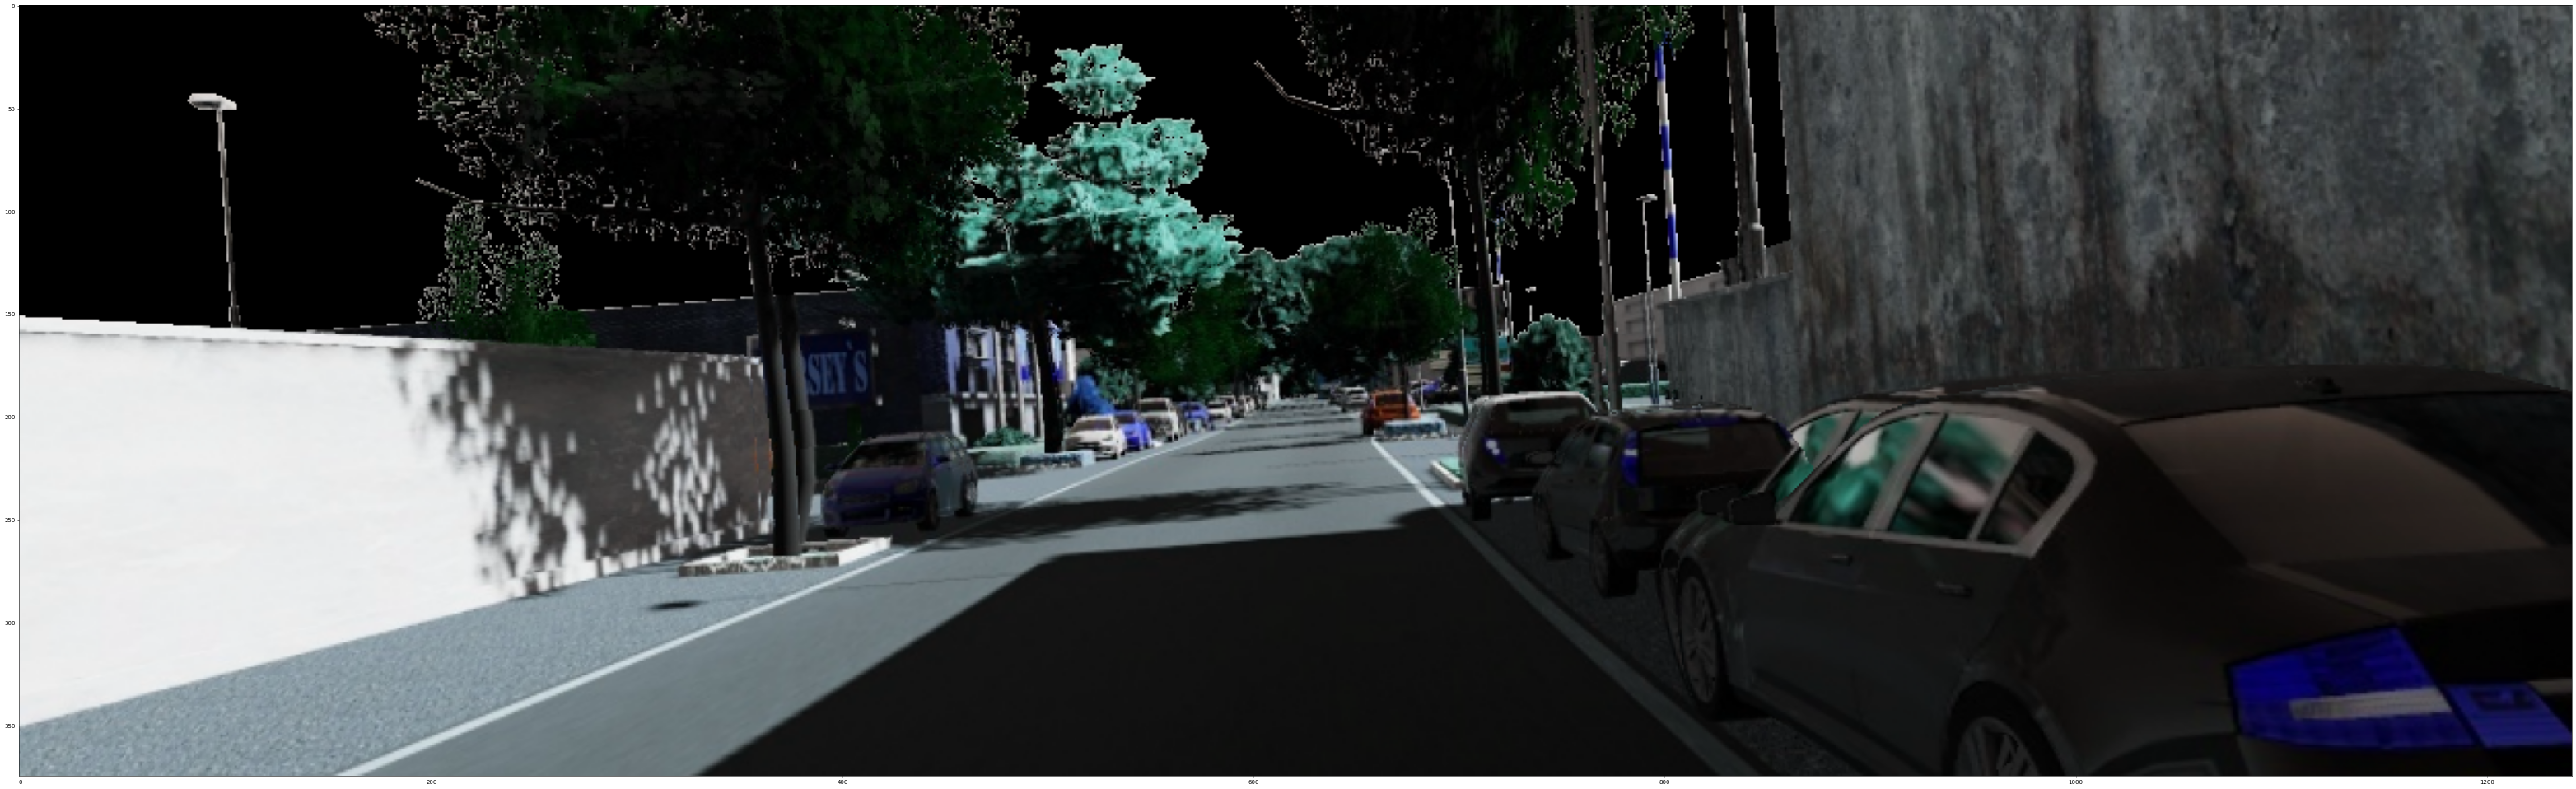

In [9]:
img1_fw = warp(torch.from_numpy(img0).float().cuda(), torch.from_numpy(ff).cuda()).squeeze().cpu().numpy().astype('uint8').transpose(1, 2, 0)
img_backwarp = warp(torch.from_numpy(img0).float().cuda(), torch.from_numpy(bf).cuda()).squeeze().cpu().numpy().astype('uint8').transpose(1, 2, 0)
import matplotlib.pyplot as plt
plt.figure(figsize=(80, 80), dpi=50)
# plt.subplot(1, 3, 1)
# plt.imshow(img1.squeeze().transpose(1, 2, 0), cmap='gray')
# plt.subplot(1, 3, 2)
# plt.imshow(img0.squeeze().transpose(1, 2, 0), cmap='gray')
plt.subplot(1, 1, 1)
plt.imshow(img_backwarp, cmap='gray')

In [71]:
fl = cv2.imread("/home/runqiu/code/imagewarp/backwardFlow_00001.png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

array([[[[  0.      ,   0.      ,   0.      , ..., 121.81822 ,
          122.23482 , 122.689285],
         [  0.      ,   0.      ,   0.      , ..., 121.78035 ,
          122.23482 , 122.65141 ],
         [  0.      ,   0.      ,   0.      , ..., 121.78035 ,
          122.196945, 122.61354 ],
         ...,
         [-89.13383 , -89.05808 , -88.98234 , ..., 356.21353 ,
          356.8195  , 357.46332 ],
         [-89.89134 , -89.777725, -89.70198 , ..., 356.02417 ,
          356.63013 , 357.27396 ],
         [-90.610916, -90.4973  , -90.421555, ..., 355.8348  ,
          356.47864 , 357.0846  ]],

        [[  0.      ,   0.      ,   0.      , ..., -36.095985,
          -36.164467, -36.23295 ],
         [  0.      ,   0.      ,   0.      , ..., -35.901955,
          -35.959023, -36.027504],
         [  0.      ,   0.      ,   0.      , ..., -35.696487,
          -35.76497 , -35.82206 ],
         ...,
         [ 21.908669,  21.93154 ,  21.942953, ..., 108.28793 ,
          108.31076 , 108

In [72]:
bf

array([[[[   0.      ,    0.      ,    0.      , ...,  -87.16447 ,
           -87.3917  ,  -87.65681 ],
         [   0.      ,    0.      ,    0.      , ...,  -87.126595,
           -87.3917  ,  -87.65681 ],
         [   0.      ,    0.      ,    0.      , ...,  -87.126595,
           -87.3917  ,  -87.65681 ],
         ...,
         [  71.18205 ,   71.10631 ,   71.03056 , ..., -194.9507  ,
          -195.40517 , -195.85963 ],
         [  71.63652 ,   71.560776,   71.44716 , ..., -194.98857 ,
          -195.48091 , -195.97325 ],
         [  72.053116,   71.97737 ,   71.90163 , ..., -195.02644 ,
          -195.51878 , -196.01112 ]],

        [[   0.      ,    0.      ,    0.      , ...,   26.086124,
            26.120365,   26.143192],
         [   0.      ,    0.      ,    0.      , ...,   25.937748,
            25.971989,   26.00623 ],
         [   0.      ,    0.      ,    0.      , ...,   25.800785,
            25.823612,   25.857853],
         ...,
         [ -17.40026 ,  -17.411674